In [129]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [8]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [9]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 23073 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## TF gene transcript detection

What fraction of TF genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [10]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='tf')

# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', subset='tf')

n_tf = len(gene_df.index)
n_det_tf = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated TF genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_tf, n_tf))

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 4304
Detected 1271 / 1419 annotated TF genes w/ at least 1 known transcript >= 1 TPM


Which TF has the most isoforms overall? 

In [7]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='all', 
                       nov=['Known', 'NIC', 'NNC'])
gene_df, _, _ = get_gtf_info(how='gene')
df = df.merge(gene_df[['gid', 'gname']], 
              how='left', 
              left_index=True, 
              right_on='gid')
df = df.sort_values(by='all', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201


,all,gid,gname
296,27,ENSG00000074800.15,ENO1
28813,25,ENSG00000095794.19,CREM
50804,24,ENSG00000181666.17,HKR1
16169,23,ENSG00000081189.15,MEF2C
48103,21,ENSG00000177426.20,TGIF1
48846,21,ENSG00000196628.16,TCF4
10481,21,ENSG00000114861.20,FOXP1
50642,20,ENSG00000089335.20,ZNF302
30665,20,ENSG00000005801.17,ZNF195
22371,19,ENSG00000197343.10,ZNF655


Which TF has the most isoforms expressed in a single sample? 

In [8]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])
df['max_sample'] = df.max(1)
df = df['max_sample'].to_frame()

gene_df, _, _ = get_gtf_info(how='gene')
df = df.merge(gene_df[['gid', 'gname']], 
              how='left', 
              left_index=True, 
              right_on='gid')

df = df.sort_values(by='max_sample', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201
Found 31 total samples


,max_sample,gid,gname
296,25.0,ENSG00000074800.15,ENO1
28813,21.0,ENSG00000095794.19,CREM
50804,20.0,ENSG00000181666.17,HKR1
15672,18.0,ENSG00000062194.15,GPBP1
50642,17.0,ENSG00000089335.20,ZNF302
38047,17.0,ENSG00000198176.12,TFDP1
48846,17.0,ENSG00000196628.16,TCF4
48103,16.0,ENSG00000177426.20,TGIF1
30533,16.0,ENSG00000185507.20,IRF7
10481,16.0,ENSG00000114861.20,FOXP1


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [11]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 67059


In [12]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [13]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [14]:
#### temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,16656,19969,0.834093
0,lncRNA,4087,15006,0.272358
2,other,1339,7426,0.180312
4,pseudogene,2330,14497,0.160723
1,miRNA,246,1881,0.130781


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 TPM?

In [15]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [16]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,56835.0,151259,0.375746
0,lncRNA,5891.0,28478,0.206861
2,pseudogene,2743.0,17657,0.155349
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469
Found 31 total samples


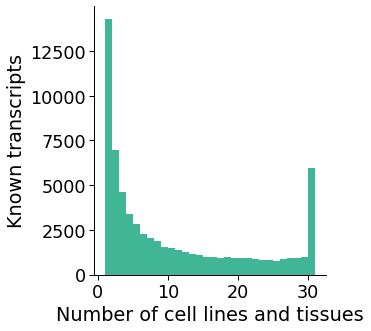

In [9]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [19]:
specific_thresh = 4
ubiq_thresh = 20

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

29214 / 65469 (44.6%) transcripts are expressed in <= 4 samples
14674 / 65469 (22.4%) transcripts are expressed in >= 20 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 68897


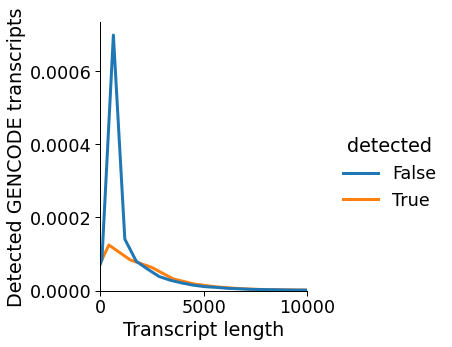

In [20]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

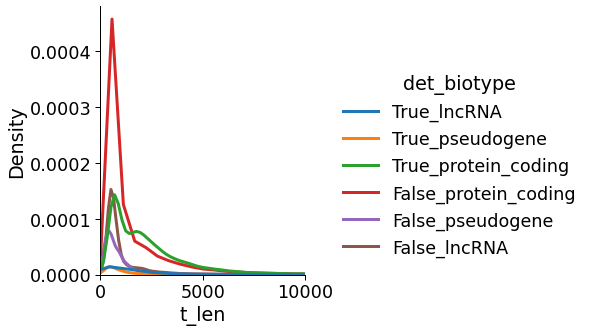

In [21]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [22]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [23]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [24]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [25]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,biotype,biotype_category,tf,detected,det_biotype,n_exons
65322,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,antisense,lncRNA,False,True,True_lncRNA,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [26]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


## How many known polyA transcripts do we detect?

In [29]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [30]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [31]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 65469 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [32]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


  transcript_novelty  counts
0              Known   68897
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 92963


<Figure size 288x432 with 0 Axes>

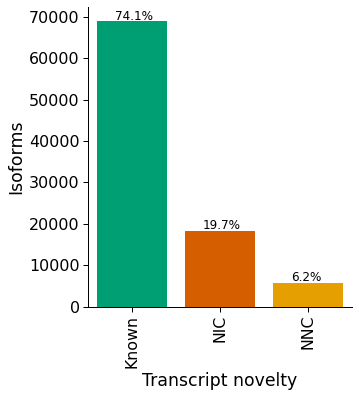

<Figure size 432x288 with 0 Axes>

In [33]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


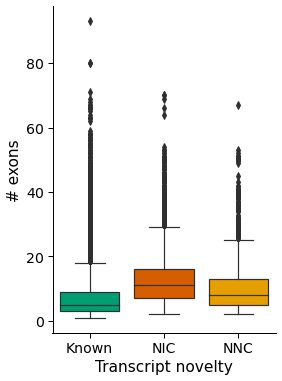

In [34]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [4]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [5]:
df.idxmax(axis=1)

annot_gene_id
ENSG00000000003.14              colon
ENSG00000000005.5        h9_panc_beta
ENSG00000000419.12    h9_neural_crest
ENSG00000000457.13    h9_neural_crest
ENSG00000000460.16     h9_panc_progen
                           ...       
ENSG00000285944.1               heart
ENSG00000285966.1               hffc6
ENSG00000285967.1          h9_chondro
ENSG00000285972.1               colon
ENSG00000285976.1             adipose
Length: 23990, dtype: object

In [6]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean()))

Average # isoforms / gene / sample: 2.721653283480311


In [7]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max()))

Max # isoforms / gene / sample: 134.0


How does the total # of isoforms we detect / gene compare to the number of annotated isoforms / gene

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


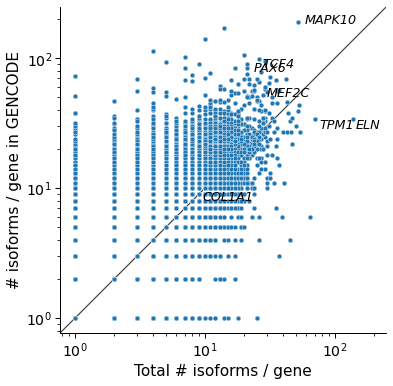

In [24]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
genes = ['ELN', 'DES', 'TPM1', 'MEF2C',
         'MYH7', 'MAPK10', 'PAX6', 'TCF4', 'COL1A1']
df = plot_det_vs_gencode_isos(df, 
                         min_tpm=1,
                         gene_subset='polya',
                         nov=['Known', 'NIC', 'NNC'],
                         label_genes=genes, 
                         opref='figures/human')

In [15]:
entry = df.sort_values(by='n_isos_gencode', ascending=False).head(1)
print('{} has the most annotated isoforms in GENCODE ({})'.format(entry.gname.values[0], entry.n_isos_gencode.values[0]))

MAPK10 has the most annotated isoforms in GENCODE (192)


In [17]:
df.sort_values(by='n_isos_gencode', ascending=False).head()

,n_isos_det,gid,n_isos_gencode,gname
3476,52,ENSG00000109339.21,192,MAPK10
13238,14,ENSG00000179818.13,170,PCBP1-AS1
19124,10,ENSG00000242086.8,142,MUC20-OT1
23912,4,ENSG00000285219.1,113,AL591485.1
17279,20,ENSG00000227036.7,106,LINC00511


In [46]:
df.loc[df.gname == 'COL1A1']

,n_isos_det,gid,n_isos_gencode,gname
3409,3,ENSG00000108821.13,13,COL1A1


In [87]:
df.loc[df.gname == 'DES']

,n_isos_det,gid,n_isos_gencode,gname,ratio
12562,45,ENSG00000175084.11,4,DES,11.25


In [86]:
df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
df.sort_values(by='ratio', ascending=False)
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 15]

,n_isos_det,gid,n_isos_gencode,gname,ratio
17279,20,ENSG00000227036.7,106,LINC00511,0.188679
175,17,ENSG00000007372.22,84,PAX6,0.202381
14928,21,ENSG00000196628.16,90,TCF4,0.233333
4192,16,ENSG00000115355.16,68,CCDC88A,0.235294
5436,21,ENSG00000126091.20,85,ST3GAL3,0.247059
...,...,...,...,...,...
12562,45,ENSG00000175084.11,4,DES,11.250000
15163,37,ENSG00000197616.11,3,MYH6,12.333333
21679,18,ENSG00000267110.1,1,AC010327.1,18.000000
1872,25,ENSG00000092054.12,1,MYH7,25.000000


How does TPM for a gene in a sample relate to the number of models we see in a sample?

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Averaging over biosample
Found 31 total samples
Number of genes reported: 31968
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


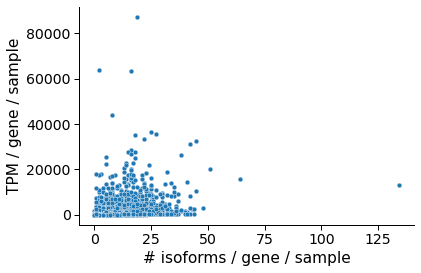

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_gene_tpm_v_n_isos(df, filt_df, 
                            min_tpm=1, 
                            groupby='sample', 
                            gene_subset='polya', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

In [4]:
df.loc[(df.gname == 'ELN')&(df.biosample == 'h9_chondro')]

,annot_gene_id,biosample,tpm,n_iso,gid,gname
160502,ENSG00000049540.16,h9_chondro,13063.607528,134.0,ENSG00000049540.16,ELN


In [5]:
df.loc[df.tpm > 40000]

,annot_gene_id,biosample,tpm,n_iso,gid,gname
163395,ENSG00000108821.13,h9_chondro,63934.387848,2.0,ENSG00000108821.13,COL1A1
609105,ENSG00000087086.14,liver,44143.313758,8.0,ENSG00000087086.14,FTL
618203,ENSG00000163631.16,liver,87160.201515,19.0,ENSG00000163631.16,ALB
938876,ENSG00000167552.13,pgp1_excite_neuron,63368.654759,16.0,ENSG00000167552.13,TUBA1A


In [6]:
df.loc[df.gname == 'COL1A1'].head()

,annot_gene_id,biosample,tpm,n_iso,gid,gname
3555,ENSG00000108821.13,adipose,131.496029,1.0,ENSG00000108821.13,COL1A1
35523,ENSG00000108821.13,adrenal gland,110.667449,1.0,ENSG00000108821.13,COL1A1
67491,ENSG00000108821.13,colon,131.359809,1.0,ENSG00000108821.13,COL1A1
99459,ENSG00000108821.13,gm12878,4.240709,0.0,ENSG00000108821.13,COL1A1
131427,ENSG00000108821.13,h9,111.554157,1.0,ENSG00000108821.13,COL1A1


How does the average number of exons in a gene relate to the number of isoforms we detect for that gene?

In [88]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [100]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')

In [101]:
g_df = df.copy(deep=True)

In [102]:
g_df = g_df[['n_exons', 'annot_gene_id', 'annot_gene_name']]
g_df = g_df.groupby(['annot_gene_id', 'annot_gene_name']).mean().reset_index()
g_df.rename({'n_exons':'avg_exons'}, axis=1, inplace=True)

In [103]:
g_df.head()

,annot_gene_id,annot_gene_name,avg_exons
0,ENCODEHG000058784,ENCODEHG000058784,7.833333
1,ENCODEHG000058787,ENCODEHG000058787,1.000000
2,ENCODEHG000058790,ENCODEHG000058790,1.000000
3,ENCODEHG000058793,ENCODEHG000058793,1.000000
4,ENCODEHG000058796,ENCODEHG000058796,1.000000


In [104]:
# detected isoforms
df = get_isos_per_gene(df,
                   min_tpm=min_tpm,
                   gene_subset=gene_subset,
                   groupby='all', 
                   nov=nov)
df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)
df.head()

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


,n_isos_det
annot_gene_id,
ENSG00000000003.14,7
ENSG00000000005.5,1
ENSG00000000419.12,7
ENSG00000000457.13,5
ENSG00000000460.16,7


In [105]:
# merge with # isos detected
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')
df.head()

,n_isos_det,annot_gene_id,annot_gene_name,avg_exons
9845,7,ENSG00000000003.14,TSPAN6,6.333333
9846,1,ENSG00000000005.5,TNMD,5.000000
9847,7,ENSG00000000419.12,DPM1,7.222222
9848,5,ENSG00000000457.13,SCYL3,13.000000
9849,7,ENSG00000000460.16,C1orf112,21.428571


In [120]:
xlim = 0
ylim = 0
label_genes = ['ELN', 'DES', 'TPM1', 'MYH7', 
               'SFTPA1', 'MGAT1', 'DYSF', 
               'COL16A1']

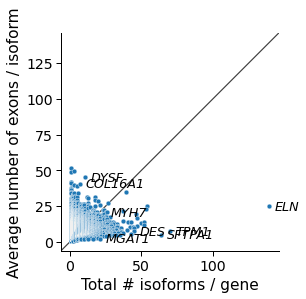

In [121]:
# plot the figure
sns.set_context('paper', font_scale=1.6)
ax = sns.scatterplot(data=df, x='n_isos_det', y='avg_exons')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set x and y lims if provided
if xlim:
    xlim = (0, xlim)
    ax.set(xlim=xlim)
if ylim:
    ylim = (0, ylim)
    ax.set(ylim=ylim)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# annotate genes that are kinda interesting
if label_genes:
    xlim = ax.get_xlim()[1]
    ylim = ax.get_ylim()[1]
    for g in label_genes:
        x = df.loc[df.annot_gene_name == g, 'n_isos_det'].values[0]+(2/75)*xlim
        y = df.loc[df.annot_gene_name == g, 'avg_exons'].values[0]-(1.5/75)*ylim
        plt.annotate(g, (x,y), fontsize='small', fontstyle='italic')

xlabel = 'Total # isoforms / gene'
ylabel = 'Average number of exons / isoform'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_det_v_exons.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')


In [119]:
df['ratio'] = df.n_isos_det / df.avg_exons
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 5]

,n_isos_det,annot_gene_id,annot_gene_name,avg_exons,ratio
11436,7,ENSG00000084636.17,COL16A1,40.833333,0.171429
10647,6,ENSG00000060718.21,COL11A1,34.530303,0.173760
19052,6,ENSG00000153956.15,CACNA2D1,27.375000,0.219178
16647,11,ENSG00000135636.13,DYSF,45.250000,0.243094
18360,6,ENSG00000147202.17,DIAPH2,24.142857,0.248521
...,...,...,...,...,...
11893,43,ENSG00000099622.13,CIRBP,5.945455,7.232416
27713,20,ENSG00000214022.11,REPIN1,2.565217,7.796610
16005,21,ENSG00000131446.16,MGAT1,2.458333,8.542373
17442,70,ENSG00000140416.20,TPM1,7.455357,9.389222


For genes where we detect a lot more isoforms than those annotated, are there typically more NIC or NNC?

In [18]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
min_tpm=1
gene_subset='polya'
nov=['Known', 'NIC', 'NNC']
opref='figures/human'

In [19]:
df_back = df.copy(deep=True)

In [20]:
# detected isoforms
det_df = get_isos_per_gene(df,
                   min_tpm=min_tpm,
                   gene_subset=gene_subset,
                   groupby='all', 
                   nov=nov)
det_df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)

# annotated isoforms
gc_df = get_n_gencode_isos(subset='polya')
gc_df = gc_df[['gid', 'n_isos_gencode']]

df = det_df.merge(gc_df, how='left', left_index=True, right_on='gid')    

# add gene name 
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname']]
df = df.merge(gene_df, how='left', on='gid')

df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
gids = df.loc[df['ratio']>1.5, 'gid'].tolist()
len(df.loc[df['ratio']>1.5])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


833

In [21]:
t_df = df_back.copy(deep=True)
t_df = t_df[['annot_transcript_id', 'transcript_novelty', 'annot_gene_id', 'annot_gene_name']]
df = get_det_table(df_back, 
                   how='iso', 
                   min_tpm=1, 
                   gene_subset='polya',
                   groupby='all',
                   nov=['Known', 'NIC', 'NNC'])
df = df.transpose()

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


In [22]:
df = df.merge(t_df, how='left', left_index=True, right_on='annot_transcript_id')
df = df.loc[df.annot_gene_id.isin(gids)]

df.drop('all', axis=1, inplace=True)
df = df.groupby(['annot_gene_id', 'annot_gene_name', 'transcript_novelty'], dropna=False).count().reset_index()
df.rename({'annot_transcript_id': 'n_isos'}, axis=1, inplace=True)
df.head()

,annot_gene_id,annot_gene_name,transcript_novelty,n_isos
0,ENSG00000001036.13,FUCA2,Known,1
1,ENSG00000001036.13,FUCA2,NIC,3
2,ENSG00000001036.13,FUCA2,NNC,3
3,ENSG00000004142.11,POLDIP2,Known,2
4,ENSG00000004142.11,POLDIP2,NIC,1


<Figure size 288x432 with 0 Axes>

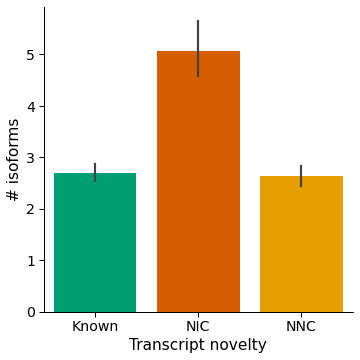

In [23]:
# plot the plot
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(4,6))

c_dict, order = get_talon_nov_colors(cats=nov)
# ax = sns.boxplot(data=df, x='transcript_novelty', y='n_isos',
#                  order=order, palette=c_dict,
#                  saturation=1)

ax = sns.catplot(data=df, x='transcript_novelty', y='n_isos',
                 order=order, palette=c_dict, kind='bar', saturation=1)


# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

xlabel = 'Transcript novelty'
ylabel = '# isoforms'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_per_many_iso_gene.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')

How does the max # isoforms detected per gene / sample compare to the number of isoforms detected per gene overall across the whole dataset?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


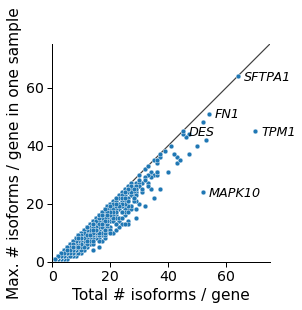

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_max_vs_all_isos(df,
                         min_tpm=1,
                         gene_subset='polya',
                         nov=['Known', 'NIC', 'NNC'],
                         label_genes=['TPM1', 'DES', 'MAPK10', 'FN1', 'SFTPA1', 'ELN'],
                         xlim=75,
                         ylim=75,
                         opref='figures/human')

In [5]:
df.loc[df.gname=='ELN']

,max_isos,total_isos,gid,gname,length,biotype,biotype_category,tf
21978,134.0,139,ENSG00000049540.16,ELN,42118,protein_coding,protein_coding,False


In [3]:
df['ratio'] = df['max_isos'] / df['total_isos']

In [4]:
df.loc[df['total_isos'] > 50].sort_values(by='ratio', ascending=True)

,max_isos,total_isos,gid,gname,length,biotype,biotype_category,tf,ratio
13592,24.0,52,ENSG00000109339.21,MAPK10,604618,protein_coding,protein_coding,False,0.461538
41480,45.0,70,ENSG00000140416.20,TPM1,29283,protein_coding,protein_coding,False,0.642857
16259,42.0,53,ENSG00000153113.23,CAST,254328,protein_coding,protein_coding,False,0.792453
45297,48.0,52,ENSG00000072778.19,ACADVL,8148,protein_coding,protein_coding,False,0.923077
8755,51.0,54,ENSG00000115414.18,FN1,75732,protein_coding,protein_coding,False,0.944444
21978,134.0,139,ENSG00000049540.16,ELN,42118,protein_coding,protein_coding,False,0.964029
29532,64.0,64,ENSG00000122852.14,SFTPA1,4516,protein_coding,protein_coding,False,1.000000


In [6]:
df.loc[df.gname == 'ELN']

,max_isos,total_isos,gid,gname,length,biotype,biotype_category,tf,ratio
21978,134.0,139,ENSG00000049540.16,ELN,42118,protein_coding,protein_coding,False,0.964029


What # of genes do we detect >15 isoforms overall that have >15 annotated isoforms in GENCODE?

In [55]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='all', 
                       nov=['Known', 'NIC', 'NNC'])
df.head()

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


,all
annot_gene_id,
ENSG00000000003.14,7
ENSG00000000005.5,1
ENSG00000000419.12,7
ENSG00000000457.13,5
ENSG00000000460.16,7


In [56]:
df = df.loc[df['all'] > 15]

In [57]:
gene_df, _, _ = get_gtf_info(how='iso', subset='polya')
gene_df = gene_df[['gid', 'tid']]
gene_df = gene_df.groupby('gid').count().reset_index()
gene_df.rename({'tid': 'n_isos_gencode'}, axis=1, inplace=True)
gene_df.sort_values(by='n_isos_gencode', ascending=False, inplace=True)
gene_df = gene_df.loc[gene_df.n_isos_gencode > 15]

# get intersection of genes wih >15 annotated isoforms and 
# genes that we detect >15 isoforms in at least one sample
n = len(set(gene_df.gid.tolist())&set(df.index.tolist()))
total = len(df.index)

print('{} / {} genes w/ >15 isoforms detected overall have >15 isoforms annotated in GENCODE'.format(n, total))

365 / 538 genes w/ >15 isoforms detected overall have >15 isoforms annotated in GENCODE


Deeper dive into what's going on with _ELN_

In [8]:
temp = df.max(axis=1).to_frame()
temp.loc[temp[0] == 134]

,0
annot_gene_id,
ENSG00000049540.16,134.0


In [9]:
df.loc['ENSG00000049540.16'].idxmax()

'h9_chondro'

In [10]:
df.loc['ENSG00000049540.16', 'h9_chondro']

134.0

How many different tissues express Elastin? How many isoforms are detected in these tissues?

In [11]:
df.loc['ENSG00000049540.16']

adipose                 7.0
adrenal gland           1.0
colon                  12.0
gm12878                 NaN
h9                      NaN
h9_chondro            134.0
h9_de                   NaN
h9_neural_crest         NaN
h9_osteocyte            NaN
h9_panc_beta            NaN
h9_panc_progen          NaN
hct116                  NaN
heart                  41.0
hepg2                   NaN
hffc6                   2.0
hl60                    NaN
imr90                   3.0
k562                    NaN
kidney                  6.0
liver                   4.0
lung                   18.0
mcf7                    NaN
muscle                  5.0
ovary                   7.0
panc1                   NaN
pc3                     NaN
pgp1                    NaN
pgp1_astro              2.0
pgp1_endo               4.0
pgp1_excite_neuron      NaN
vessels                41.0
Name: ENSG00000049540.16, dtype: float64

What novelty type do each of these isoforms have across samples?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


<Figure size 288x432 with 0 Axes>

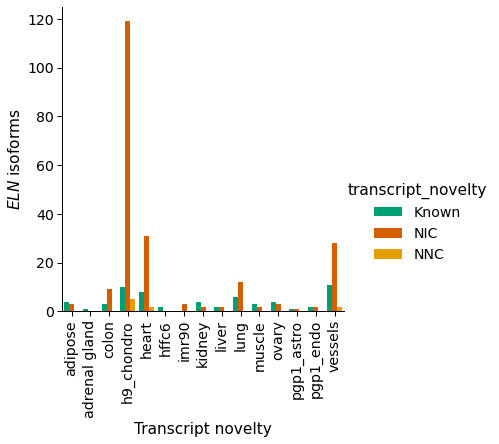

In [5]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='ELN', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


<Figure size 288x432 with 0 Axes>

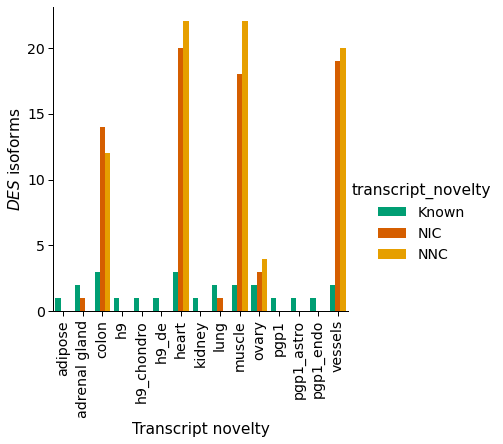

In [4]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='DES', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


<Figure size 288x432 with 0 Axes>

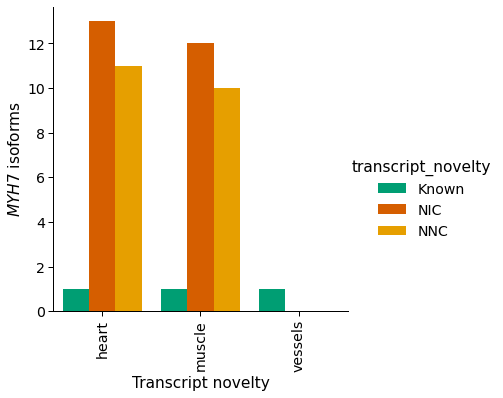

In [7]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='MYH7', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

What novelty type do each of these isoforms have in just h9 chondro?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


<Figure size 288x432 with 0 Axes>

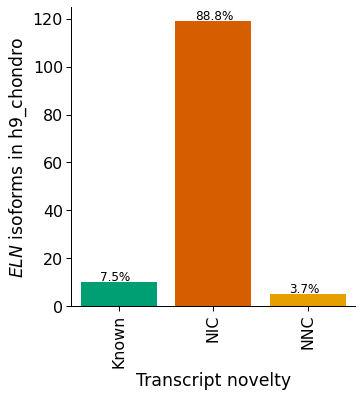

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per_1(df, 
                            dataset='h9_chondro',
                            gene='ELN',
                            min_tpm=1,
                            gene_subset='polya',
                            groupby='sample',
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

Which samples have the highest average?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


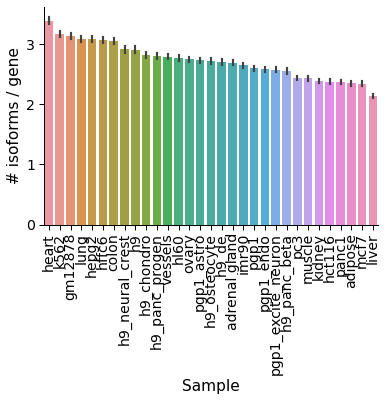

In [27]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

Calculating iso TPM values
Subsetting for tissue datasets
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 124187
Applying gene type and novelty subset
Number of isos reported: 78703
Found 10 total samples


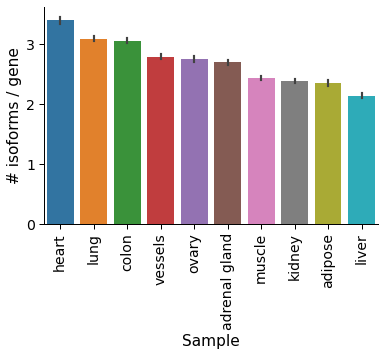

In [28]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='tissue', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

What's the distribution of number of isoforms detected per gene per sample?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


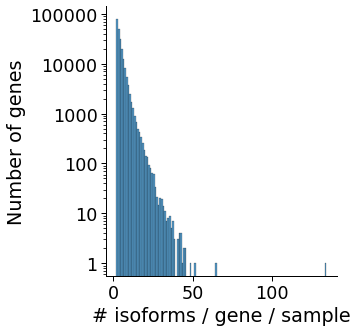

In [29]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, ax = plot_isos_per_gene_hist(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'],
                       rm_1=True)

How many genes have >15, >10 isoforms expressed in a sample?

In [47]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [48]:
df = df.loc[(df > 10).any(axis=1)]
n = len(df.index)
print('{} genes with >10 complete isoforms / gene in at least one sample'.format(n))

1013 genes with >10 complete isoforms / gene in at least one sample


In [49]:
print(len(df.index))
df.head()

1013


,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,mcf7,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels
annot_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000002586.19,6.0,9.0,9.0,8.0,3.0,7.0,4.0,5.0,5.0,4.0,...,2.0,6.0,10.0,2.0,2.0,3.0,6.0,8.0,4.0,10.0
ENSG00000002822.15,13.0,8.0,11.0,15.0,16.0,10.0,15.0,14.0,10.0,10.0,...,11.0,9.0,13.0,10.0,8.0,10.0,11.0,10.0,11.0,17.0
ENSG00000003147.18,4.0,3.0,10.0,2.0,7.0,2.0,4.0,2.0,1.0,5.0,...,5.0,2.0,3.0,NaN,3.0,7.0,5.0,8.0,5.0,4.0
ENSG00000003402.19,8.0,8.0,8.0,14.0,2.0,3.0,6.0,3.0,3.0,3.0,...,2.0,7.0,5.0,2.0,2.0,4.0,7.0,9.0,5.0,8.0
ENSG00000003436.15,6.0,6.0,4.0,3.0,1.0,8.0,3.0,3.0,10.0,3.0,...,6.0,6.0,6.0,6.0,7.0,NaN,5.0,11.0,NaN,7.0


In [142]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos',
                outdir='highly_spliced_isos_GO',
                cutoff=0.5)

In [50]:
df = df.loc[(df > 15).any(axis=1)]
n = len(df.index)
print('{} genes with >15 complete isoforms / gene in at least one sample'.format(n))

306 genes with >15 complete isoforms / gene in at least one sample


In [7]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos_15',
                outdir='highly_spliced_isos_15_GO',
                cutoff=0.5)

How many of these genes have >15 annotated isoforms / gene? 

In [54]:
gene_df, _, _ = get_gtf_info(how='iso', subset='polya')
gene_df = gene_df[['gid', 'tid']]
gene_df = gene_df.groupby('gid').count().reset_index()
gene_df.rename({'tid': 'n_isos_gencode'}, axis=1, inplace=True)
gene_df.sort_values(by='n_isos_gencode', ascending=False, inplace=True)
gene_df = gene_df.loc[gene_df.n_isos_gencode > 15]

# get intersection of genes wih >15 annotated isoforms and 
# genes that we detect >15 isoforms in at least one sample
n = len(set(gene_df.gid.tolist())&set(df.index.tolist()))
total = len(df.index)

print('{} / {} genes w/ >15 isoforms detected in one sample have >15 isoforms annotated in GENCODE'.format(n, total))

192 / 306 genes w/ >15 isoforms detected in one sample have >15 isoforms annotated in GENCODE


What are the identities of highly-spliced genes?

In [37]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [38]:
df['max_isos_sample'] = df.max(axis=1)
df['max_sample'] = df.idxmax(axis=1)
df = df[['max_isos_sample', 'max_sample']]
df = df.sort_values('max_isos_sample', ascending=False)

In [39]:
g_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
g_df = g_df[['annot_gene_name', 'annot_gene_id']].drop_duplicates()
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')

In [40]:
print('Top 10 genes with isoforms / gene / sample')
df.head(10)

Top 10 genes with isoforms / gene / sample


,max_isos_sample,max_sample,annot_gene_name,annot_gene_id
31360,134.0,h9_chondro,ELN,ENSG00000049540.16
41318,64.0,lung,SFTPA1,ENSG00000122852.14
12524,51.0,h9_chondro,FN1,ENSG00000115414.18
64923,48.0,heart,ACADVL,ENSG00000072778.19
12821,45.0,heart,DES,ENSG00000175084.11
58348,45.0,heart,TPM1,ENSG00000140416.20
33987,44.0,heart,CTSB,ENSG00000164733.20
27826,44.0,heart,SLC29A1,ENSG00000112759.17
23678,43.0,heart,PAM,ENSG00000145730.20
23610,42.0,heart,CAST,ENSG00000153113.23


In [41]:
# save table 
df.to_csv('isos_per_gene_per_sample_min_15.tsv', sep='\t')

Number of libraries per sample

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Slope of correlation: 0.06860873899624846
R of correlation: 0.6894778034661756
R2 of correlation: 0.8220809043849258


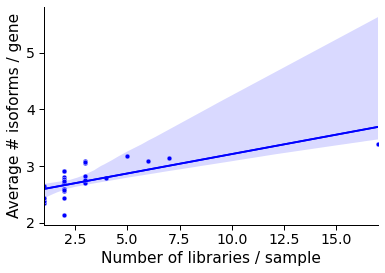

In [35]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_libs_v_avg_isos(df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Number of reads per sample

Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Slope of correlation: 5.3768968831182704e-08
R of correlation: 0.7143535392911774
R2 of correlation: 0.7495967741935485


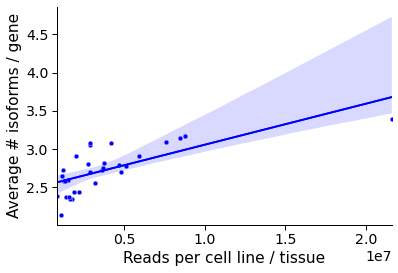

In [36]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

In [51]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='polya',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 31968
Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [52]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected polyA genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

8274 / 31968 detected polyA genes express >=2 isoforms in at least half of their expressed samples


What fraction of TF genes express >= 2 complete isoforms in more than half of their expressed samples?


In [59]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='tf',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 1355
Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201
Found 31 total samples


In [60]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected TF genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

518 / 1355 detected TF genes express >=2 isoforms in at least half of their expressed samples


What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [61]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [62]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

10672 / 49472 annotated polyA genes have >= 2 isoforms expressed in >= 1 sample


What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [63]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201
Found 31 total samples


In [64]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

698 / 1419 annotated TF genes have >= 2 isoforms expressed in >= 1 sample
